<a href="https://colab.research.google.com/github/alexgaskell10/NLP_Translation/blob/master/notebooks/stuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
! pip install transformers

In [5]:
import torch
from torch.nn import Linear, ModuleList
from torch import optim
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import random
import time
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
torch.set_printoptions(2)

In [6]:
# ############ ENGLISH - CHINESE ############

# Download and unzip the data
from os.path import exists
if not exists('enzh_data.zip'):
    !wget -O enzh_data.zip https://competitions.codalab.org/my/datasets/download/03e23bd7-8084-4542-997b-6a1ca6dd8a5f
    !unzip enzh_data.zip

# Load data into variables
with open("./train.enzh.src", "r") as ende_src:
    en_corpus = ende_src.read().split('\n')[:-1]
with open("./train.enzh.mt", "r") as ende_src:
    de_corpus = ende_src.read().split('\n')[:-1]
with open("./train.enzh.scores", "r") as ende_src:
    scores = [float(x) for x in ende_src.read().split('\n')[:-1]]

print(en_corpus[0])
print(de_corpus[0])
print(scores[0])

The last conquistador then rides on with his sword drawn.
最后的征服者骑着他的剑继续前进.
-1.5284005772625449


In [0]:
# ########### ENGLISH - GERMAN ############

# # Download and unzip the data
# from os.path import exists
# if not exists('ende_data.zip'):
#     !wget -O ende_data.zip https://competitions.codalab.org/my/datasets/download/c748d2c0-d6be-4e36-9f12-ca0e88819c4d
#     !unzip ende_data.zip

# # Load data into variables
# with open("./train.ende.src", "r") as ende_src:
#     en_corpus = ende_src.read().split('\n')[:-1]
# with open("./train.ende.mt", "r") as ende_src:
#     de_corpus = ende_src.read().split('\n')[:-1]
# with open("./train.ende.scores", "r") as ende_src:
#     scores = [float(x) for x in ende_src.read().split('\n')[:-1]]

# print(en_corpus[0])
# print(de_corpus[0])
# print(scores[0])

(-2, 2)

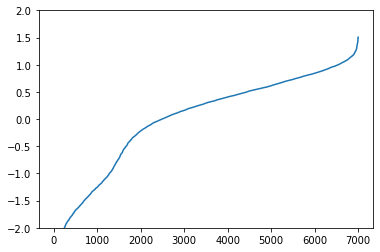

In [8]:
plt.plot(sorted(scores))
plt.ylim([-2,2])

In [0]:
class Preprocessor:
    def __init__(self, device, bert_config):
        self.device = device
        self.tokenizer = BertTokenizer.from_pretrained(bert_config)

    def get_input_tensor(self, en_corpus, de_corpus):
        # Convert input sequences to correct format
        N = len(en_corpus)

        # Tokenize corpora
        inputs_en, inputs_de = [],[]
        max_len_en, max_len_de = 0,0
            
        for i in range(N):
            # English
            seq = en_corpus[i][:-1]
            input_ids = torch.tensor([self.tokenizer.encode(seq, add_special_tokens=True)])
            inputs_en.append(input_ids)
            if input_ids.shape[-1] > max_len_en:
                max_len_en = input_ids.shape[-1]

            # German
            seq = de_corpus[i][:-1]
            input_ids = torch.tensor([self.tokenizer.encode(seq, add_special_tokens=True)])
            inputs_de.append(input_ids)
            if input_ids.shape[-1] > max_len_de:
                max_len_de = input_ids.shape[-1]

        # Combine tokens into single tensor
        inp_tensor = torch.zeros((N, max_len_en + max_len_de - 2))      # <-- -2 because special tokens are not necessary at beginning of German sequence

        for i in range(N):
            # Add English tokens
            en_tokens = inputs_en[i].squeeze()
            inp_tensor[i, : len(en_tokens)] = en_tokens

            # Add German tokens
            de_tokens = inputs_de[i][:,2:].squeeze()      # <-- ignore first 2 tokens as these are special tokens and unnecessary in this case
            inp_tensor[i, max_len_en : max_len_en + len(de_tokens)] = de_tokens

        return inp_tensor

    def attention_mask(self, list_input_tensor):
        list_attention_masks = []
        for input_tensor in list_input_tensor:
            attention_mask = torch.zeros((input_tensor.shape))
            attention_mask[input_tensor != 0] = 1
            list_attention_masks.append(attention_mask)

        return list_attention_masks

    def get_batches(self, inp_tensor, scores, BATCH_N):
        inp_tensor = inp_tensor
        scores = torch.tensor(scores).view(-1,1)

        # Split data into train, test and val batches
        inp_tensor_batches = torch.split(inp_tensor, BATCH_N)
        scores_batches = torch.split(scores, BATCH_N)
        X_train_val, X_test, y_train_val, y_test = train_test_split(inp_tensor_batches, scores_batches, random_state=1, test_size=0.1)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=1, test_size=1/9)
        print(len(X_train), X_train[0].shape)

        # Create attention masks
        X_train_mask = self.attention_mask(X_train)
        X_val_mask = self.attention_mask(X_val) 
        X_test_mask = self.attention_mask(X_test)
        print(len(X_train_mask), X_train_mask[0].shape)

        # Batch X, mask and y together
        batches_train = [(X, mask, y) for X,mask,y in zip(X_train, X_train_mask, y_train)]
        batches_val = [(X, mask, y) for X,mask,y in zip(X_val, X_val_mask, y_val)]
        batches_test = [(X, mask, y) for X,mask,y in zip(X_test, X_test_mask, y_test)]

        return batches_train, batches_val, batches_test


In [0]:
class BertRegressor:
    def __init__(self, input_shape, bert_config, device):
        self.device = device
        self.bert = BertModel.from_pretrained(bert_config).to(device)
        self.layers = ModuleList([
            Linear(in_features=input_shape[-1], out_features=1, bias=True).to(device),
            # Linear(in_features=input_shape[-1]*768, out_features=100, bias=True).to(device),            # <-- 768 is the dim of Bert embedding
            # Linear(in_features=100, out_features=1, bias=True).to(device),
        ])

    def forward_1(self, X, attention_mask=None):
        if attention_mask is not None:
            X = self.bert(X, attention_mask)[0].view(X.shape[0], -1)    
        else:
            X = self.bert(X)[0].view(X.shape[0], -1)

        X = self.layers[0](X)
        for l in self.layers[1:]:
            X = F.relu(X)
            X = l(X)

        return X

    def forward_2(self, X, attention_mask=None):
        if attention_mask is not None:
            X = self.bert(X, attention_mask)[0][:,:,0]
        else:
            X = self.bert(X)[0][:,:,0]

        X = self.layers[0](X)
        for l in self.layers[1:]:
            X = F.relu(X)
            X = l(X)

        return X


    def loss(self, scores, pred_scores):
        rmse = (((pred_scores - scores)**2).mean())**0.5
        return rmse

    def check_r(self, y_pred, y):
        return pearsonr(y_pred.cpu().squeeze(), y.cpu().squeeze())[0]

    def zero_grad(self):
        self.bert.zero_grad()
        for l in self.layers:
            l.zero_grad()

    def params(self):
        params = list(self.bert.parameters())
        for l in self.layers:
            params.extend(list(l.parameters()))
        return params

    def __call__(self, X, attention_mask=None):
        return self.forward_2(X, attention_mask)


In [11]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

bert_config = 'bert-base-multilingual-cased'
BATCH_N = 16
EPOCHS = 2
LR = 2e-5

# Set seeds
seed_val = 111
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Preprocessing
preprocessor = Preprocessor(device, bert_config)
input_tensor = preprocessor.get_input_tensor(en_corpus, de_corpus)
batches_train, batches_val, batches_test = preprocessor.get_batches(input_tensor, scores, BATCH_N)


350 torch.Size([16, 140])
350 torch.Size([16, 140])


In [0]:
# torch.cuda.empty_cache()
# model = BertRegressor(batches_train[0][0].shape, bert_config, device)

# X = batches_train[0][0].to(device, dtype=torch.long)
# mask = batches_train[0][1].to(device)
# # print(X.device, mask.device, X.requires_grad)
# print(model(X, mask).shape)
# # print(model.bert.forward(X)[0][:,:,0].shape)
# torch.cuda.empty_cache()

In [0]:
def validation(val_batches):

    print("")
    print("Running Validation...")

    t0 = time.time()
    eval_loss = 0
    correlations = []

    for batch in val_batches:        

        # Untie batch and put on GPU
        X = batch[0].to(device=device, dtype=torch.long)
        mask = batch[1].to(device)
        y = batch[2].to(device)

        with torch.no_grad():        
            y_pred = model(X)                      
                
        # Compute and record batch accuracy
        corr = model.check_r(y_pred, y)
        correlations.append(corr)

    # Report the final accuracy for this validation run.
    print(f"|  Correlation: {np.mean(correlations):.2f}     |")
    print(f"|  Validation took: {time.time() - t0:0f} s |")

    torch.cuda.empty_cache()


def train(model, train_batches, val_batches, epochs):

    losses = []
    
    for epoch_i in range(epochs):
        
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        t0 = time.time()
        total_loss = 0

        for step, batch in enumerate(train_batches):

            # Untie batch and put on GPU
            X = batch[0].to(device=device, dtype=torch.long)
            mask = batch[1].to(device)
            y = batch[2].to(device)

            model.zero_grad()                   # Reset grads
            y_pred = model(X, mask)             # Forward pass
            loss = model.loss(y, y_pred)        # Compute loss
            total_loss += loss.item()           # Accumulate loss
            loss.backward()                     # Backward pass

            optimizer.step()                    # Update params

            if step % 10 == 0:
                # Progress update every 40 batches                
                print('  Batch {:>5,}  of  {:>5,}    |    Elapsed: {:.0f}s.'.format(step, len(train_batches), time.time() - t0))
                print(f'  Loss = {loss.item():.2f}')

            torch.cuda.empty_cache()            # Clear GPU cache to avoid memory issues

        # Compute and store avg loss
        avg_train_loss = total_loss / len(X)
        losses.append(avg_train_loss)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:.0f}s".format(time.time() - t0))

        validation(val_batches) 

    print("")
    print("Training complete!")

In [0]:
torch.cuda.empty_cache()
# Model to train
model = BertRegressor(batches_train[0][0].shape, bert_config, device)

# Optimizer
optimizer = AdamW(model.params(), lr=LR, eps=1e-8)

torch.cuda.empty_cache()
train(model, batches_train, batches_val, epochs=EPOCHS)
torch.cuda.empty_cache()


======== Epoch 1 / 2 ========
Training...
  Batch     0  of    350    |    Elapsed: 1s.
  Loss = 0.66
  Batch    10  of    350    |    Elapsed: 7s.
  Loss = 0.79
  Batch    20  of    350    |    Elapsed: 13s.
  Loss = 0.88
  Batch    30  of    350    |    Elapsed: 20s.
  Loss = 0.45
  Batch    40  of    350    |    Elapsed: 26s.
  Loss = 0.84
  Batch    50  of    350    |    Elapsed: 33s.
  Loss = 0.69
  Batch    60  of    350    |    Elapsed: 39s.
  Loss = 0.97
  Batch    70  of    350    |    Elapsed: 46s.
  Loss = 1.32
  Batch    80  of    350    |    Elapsed: 52s.
  Loss = 0.92
  Batch    90  of    350    |    Elapsed: 59s.
  Loss = 0.87
  Batch   100  of    350    |    Elapsed: 65s.
  Loss = 0.78
  Batch   110  of    350    |    Elapsed: 71s.
  Loss = 0.75
  Batch   120  of    350    |    Elapsed: 78s.
  Loss = 0.80
  Batch   130  of    350    |    Elapsed: 84s.
  Loss = 1.02
  Batch   140  of    350    |    Elapsed: 91s.
  Loss = 0.62
  Batch   150  of    350    |    Elapsed: 97

In [0]:

# model = BertRegressor(batches_train[0][0].shape, bert_config, device)

# torch.cuda.empty_cache()

# X = batches_train[0][0][:10].to(device, torch.long)
# mask = batches_train[0][1][:10].to(device)
# y = batches_train[0][2][:10].to(device)

# optimizer = AdamW(model.params(), lr=LR, eps=1e-8)

# with torch.no_grad():
#     X_ = model.bert(X)[0].view(X.shape[0], -1)

# losses = []

# for i in range(len(batches_train)):

#     X = batches_train[i][0][:].to(device, torch.long)
#     mask = batches_train[i][1][:].to(device)
#     y = batches_train[i][2][:].to(device)

#     model.zero_grad()

#     X_ = model.bert(X)[0].view(X.shape[0], -1)
#     preds = model.linear(X_)
    
#     loss = model.loss(preds, y)
#     loss.backward()
#     print(i, '   ',loss)
#     optimizer.step()
#     losses.append(loss)
#     torch.cuda.empty_cache()

# plt.plot(losses)

In [0]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    